In [2]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "10_adv_problems/10b_vae.ipynb"
_nb_title = "Variational Autoencoders"
_nb_message = """
Train a variational autoencoder on MNIST.
"""
### no need to change any of this
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Variational+Autoencoders&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F10_adv_problems%2F10b_variational_autoencoders.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/10_adv_problems/10b_variational_autoencoders.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/10_adv_problems/10b_variational_autoencoders.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/10_adv_problems/10b_variational_autoencoders.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/><h1>Variational Autoencoders</h1>
Train a variational autoencoder on MNIST.


## Enable GPU
This notebook and pretty much every other notebook in this repository will run faster if you are using a GPU. 

On Colab:
* Navigate to Edit→Notebook Settings
* Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
* Navigate to https://console.cloud.google.com/ai-platform/notebooks
* Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [2]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.3.0
Found GPU at: /device:GPU:0


In [3]:
# Import libraries and modules
import matplotlib.pyplot as plt
import numpy as np
print(np.__version__)
np.set_printoptions(threshold=np.inf)

1.18.5


## Sampling Layer

Unlike non-variational autoencoders, instead of just generating points from the encoder, to better regularize the latent space we instead sample from the probability distribution based on the mean and standard deviation vector outputs from the encoder.

In [4]:
latent_dim = 3

In [5]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    """
    def call(self, inputs):
        """Calls sampling layer with prob. dist. inputs & samples from dist.

        Returns:
            Random sample from probability distribution.
        """
        z_mean, z_log_var = inputs
        batch = tf.shape(input=z_mean)[0]
        dim = tf.shape(input=z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))

        return z_mean + tf.math.exp(x=0.5 * z_log_var) * epsilon

## Vanilla Variational Autoencoders

For a vanilla variational autoencoder, we use just basic `Dense` layers for both the encoder and decoder.

In [6]:
def create_vanilla_encoder(latent_dim):
    """Creates vanilla encoder for VAE.

    Args:
        latent_dim: int, the latent vector dimension length.

    Returns:
        VAE vanilla encoder `Model`.
    """
    encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Flatten()(inputs=encoder_inputs)
    x = tf.keras.layers.Dense(units=1024, activation="relu")(inputs=x)
    x = tf.keras.layers.Dense(units=512, activation="relu")(inputs=x)
    x = tf.keras.layers.Dense(units=256, activation="relu")(inputs=x)

    z_mean = tf.keras.layers.Dense(units=latent_dim, name="z_mean")(inputs=x)
    z_log_var = tf.keras.layers.Dense(
        units=latent_dim, name="z_log_var"
    )(inputs=x)
    z = Sampling()(inputs=[z_mean, z_log_var])

    return tf.keras.Model(
        inputs=encoder_inputs,
        outputs=[z_mean, z_log_var, z],
        name="vae_vanilla_encoder"
    )

vanilla_encoder = create_vanilla_encoder(latent_dim=latent_dim)

vanilla_encoder.summary()

Model: "vae_vanilla_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         803840      flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          524800      dense[0][0]                      
________________________________________________________________________________

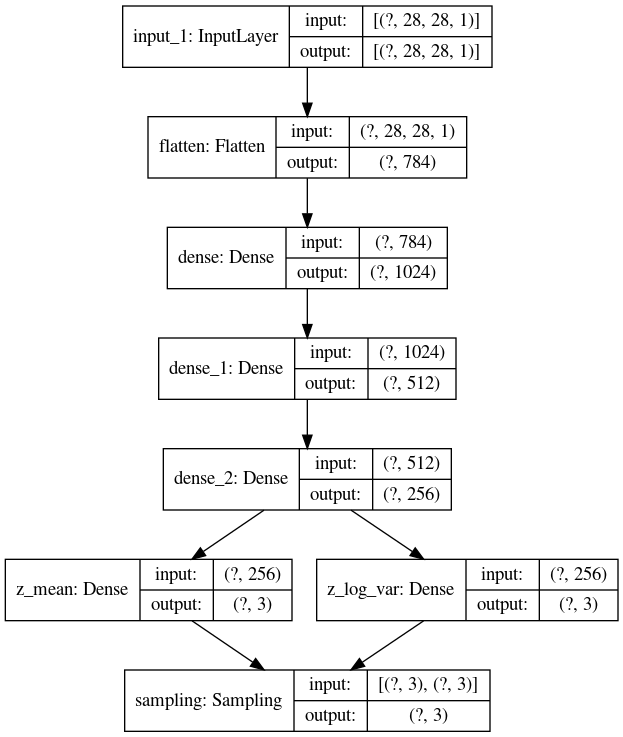

In [7]:
# Plot encoder model.
tf.keras.utils.plot_model(
    model=vanilla_encoder,
    to_file="vae_vanilla_encoder_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [8]:
def create_vanilla_decoder(latent_dim):
    """Creates vanilla decoder for VAE.

    Args:
        latent_dim: int, the latent vector dimension length.

    Returns:
        VAE vanilla decoder `Model`.
    """
    decoder_inputs = tf.keras.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(units=256, activation="relu")(
        inputs=decoder_inputs
    )
    x = tf.keras.layers.Dense(units=512, activation="relu")(inputs=x)
    x = tf.keras.layers.Dense(units=1024, activation="relu")(inputs=x)
    x = tf.keras.layers.Dense(units=28 * 28 * 1, activation="sigmoid")(
        inputs=x
    )
    decoder_outputs = tf.keras.layers.Reshape(target_shape=(28, 28, 1))(
        inputs=x
    )

    return tf.keras.Model(
        inputs=decoder_inputs,
        outputs=decoder_outputs,
        name="vae_vanilla_decoder"
    )

vanilla_decoder = create_vanilla_decoder(latent_dim=latent_dim)

vanilla_decoder.summary()

Model: "vae_vanilla_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1024      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_6 (Dense)              (None, 784)               803600    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 1,461,520
Trainable params: 1,461,520
Non-trainable params: 0
_____________________________________

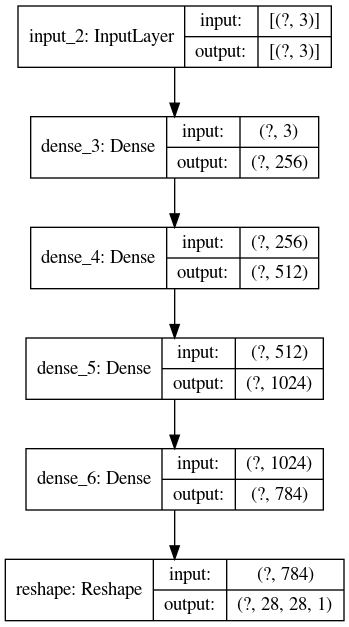

In [9]:
# Plot decoder model.
tf.keras.utils.plot_model(
    model=vanilla_decoder,
    to_file="vae_vanilla_decoder_model.png",
    show_shapes=True,
    show_layer_names=True
)

We'll create a custom `Model` class named `VAE` that we can use to facilitate training of our encoder and decoder networks.

In [10]:
class VAE(tf.keras.Model):
    """Custom model for training a variational autoencoder.

    Attributes:
        encoder: Keras `Model`, the encoder network.
        decoder: Keras `Model`, the decoder network.
        reconstruction_loss_metric: `Metric`, to track reconstruction loss.
        kl_loss_metric: `Metric`, to track KL loss.
        total_loss_metric: `Metric`, to track total loss.
        
    """
    def __init__(self, encoder, decoder, **kwargs):
        """Instantiates `VAE` model class.

        Args:
            encoder: Keras `Model`, the encoder network.
            decoder: Keras `Model`, the decoder network.
        """
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.reconstruction_loss_metric = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_metric = tf.keras.metrics.Mean(name="kl_loss")
        self.total_loss_metric = tf.keras.metrics.Mean(name="total_loss")

    @property
    def metrics(self):
        """Returns list of metrics.

        Returns:
            List of metrics.
        """
        return [
            self.reconstruction_loss_metric,
            self.kl_loss_metric,
            self.total_loss_metric,
        ]

    def train_step(self, images):
        """Trains `VAE` for one step.

        Args:
            images: tensor, rank 4 tensor of images with shape
                (batch_size, height, width, depth).

        Returns:
            losses: dict, dictionary containing scalar losses.
        """
        with tf.GradientTape(persistent=True) as tape:
            # Encode images into probability distribution parameters and
            # latent vector/code.
            z_mean, z_log_var, z = self.encoder(inputs=images)

            # Generate reconstructed images from latent vectors.
            reconstructed_images = self.decoder(inputs=z)

            reconstruction_loss = tf.math.reduce_mean(
                input_tensor=tf.math.reduce_sum(
                    input_tensor=tf.keras.losses.binary_crossentropy(
                        y_true=images, y_pred=reconstructed_images
                    ),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (
                1. + z_log_var - tf.square(x=z_mean) - tf.exp(x=z_log_var)
            )
            kl_loss = tf.reduce_mean(
                input_tensor=tf.reduce_sum(input_tensor=kl_loss, axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        # Get gradients from loss and apply to weights.
        grads = tape.gradient(
            target=total_loss, sources=self.trainable_weights
        )
        self.optimizer.apply_gradients(
            grads_and_vars=zip(grads, self.trainable_weights)
        )

        # Update metrics.
        self.reconstruction_loss_metric.update_state(
            values=reconstruction_loss
        )
        self.kl_loss_metric.update_state(values=kl_loss)
        self.total_loss_metric.update_state(values=total_loss)

        losses = {
            "reconstruction_loss": self.reconstruction_loss_metric.result(),
            "kl_loss": self.kl_loss_metric.result(),
            "loss": self.total_loss_metric.result(),
        }

        return losses
        

In [11]:
def create_dataset(batch_size, training):
    """Creates training dataset.

    Args:
        batch_size: int, number of elements in a mini-batch.
        training: bool, whether training or not.

    Returns:
        dataset: `Dataset`, dataset object for training using MNIST.
    """
    # Get and format MNIST data.
    (x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

    if training:
        images = x_train
    else:
        images = x_test

    images = images.astype("float32") / 255.0
    images = np.reshape(images, newshape=(-1, 28, 28, 1))

    # Create tf.data.Dataset for training.
    dataset = tf.data.Dataset.from_tensor_slices(tensors=images)
    if training:
        dataset = dataset.shuffle(buffer_size=70000)
    dataset = dataset.batch(batch_size=batch_size)

    return dataset


In [12]:
# Instantiate an VAE instance using our vanilla encoder and decoder.
vanilla_vae = VAE(
    encoder=vanilla_encoder, decoder=vanilla_decoder
)

vanilla_vae.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7
    )
)

# Train vanilla variational autoencoder model.
vanilla_vae_history = vanilla_vae.fit(
    create_dataset(batch_size=128, training=True), epochs=30
)

Epoch 1/30
469/469 [==============================] - 2s 4ms/step - reconstruction_loss: 167.1454 - kl_loss: 5.8514 - loss: 205.9385
Epoch 2/30
469/469 [==============================] - 2s 4ms/step - reconstruction_loss: 136.6066 - kl_loss: 7.3714 - loss: 146.3028
Epoch 3/30
469/469 [==============================] - 2s 4ms/step - reconstruction_loss: 130.8336 - kl_loss: 7.7967 - loss: 139.6543
Epoch 4/30
469/469 [==============================] - 2s 4ms/step - reconstruction_loss: 127.5951 - kl_loss: 8.0558 - loss: 135.7583
Epoch 5/30
469/469 [==============================] - 2s 4ms/step - reconstruction_loss: 125.4783 - kl_loss: 8.2111 - loss: 133.9135
Epoch 6/30
469/469 [==============================] - 2s 4ms/step - reconstruction_loss: 124.3622 - kl_loss: 8.3210 - loss: 133.0397
Epoch 7/30
469/469 [==============================] - 2s 4ms/step - reconstruction_loss: 122.8894 - kl_loss: 8.4606 - loss: 131.4232
Epoch 8/30
469/469 [==============================] - 2s 4ms/step - r

Let's plot the loss history and some generated images using our trained model.

In [13]:
def plot_loss_history(history):
    """Plots loss history.

    Args:
        history: `keras.callbacks.History`, history object from training job.
    """
    plt.plot(history.history["loss"])
    plt.title("Training loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["train_loss"], loc="upper left")
    plt.show()


In [14]:
def plot_images(images):
    """Plots images.

    Args:
        images: np.array, array of images of
            [num_images, image_size, image_size, num_channels].
    """
    num_images = len(images)

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        image = images[i]
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(
            tf.reshape(image, image.shape[:-1]),
            cmap="gray_r"
        )
    plt.show()

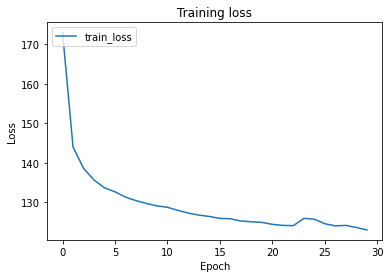

In [15]:
plot_loss_history(history=vanilla_vae_history)

Both non-variational and variational autoencoders are great at reconstruction.

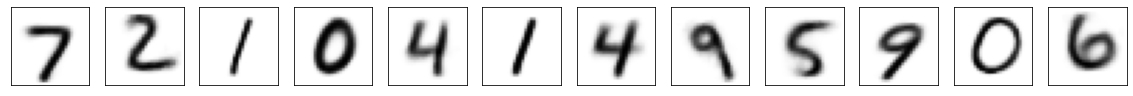

In [16]:
dataset_iter = iter(create_dataset(batch_size=12, training=False))
batch = next(dataset_iter)
plot_images(
    images=vanilla_vae.decoder(
        inputs=vanilla_vae.encoder(inputs=batch)
    )
)

In [ ]:
vanilla_vae.decoder(
    inputs=tf.random.normal(shape=(12, latent_dim))
)

And now the latent space is nicely regularized due to the variational aspect, therefore decoding a user provided latent vector performs well.

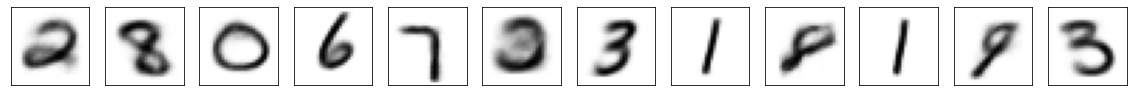

In [17]:
plot_images(
    images=vanilla_vae.decoder(
        inputs=tf.random.normal(shape=(12, latent_dim))
    )
)

## DC-VAE

A Deep-convolutional variational autoencoder (DC-VAE) uses convolutional (`Conv2D`) and deconvolutional (`Conv2DTranspose`) instead of `Dense` layers for the encoder and decoder respectively.

In [18]:
def create_dc_encoder(latent_dim):
    """Creates deep convolutional encoder for VAE.

    Args:
        latent_dim: int, the latent vector dimension length.

    Returns:
        VAE deep convolutional encoder `Model`.
    """
    encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(
        filters=32, 
        kernel_size=3, 
        strides=2, 
        padding="same", 
        activation="relu"
    )(inputs=encoder_inputs)
    x = tf.keras.layers.Conv2D(
        filters=64, 
        kernel_size=3, 
        strides=2, 
        padding="same", 
        activation="relu"
    )(inputs=x)
    x = tf.keras.layers.Flatten()(inputs=x)
    x = tf.keras.layers.Dense(units=16, activation="relu")(inputs=x)

    z_mean = tf.keras.layers.Dense(units=latent_dim, name="z_mean")(inputs=x)
    z_log_var = tf.keras.layers.Dense(units=latent_dim, name="z_log_var")(
        inputs=x
    )
    z = Sampling()(inputs=[z_mean, z_log_var])

    return tf.keras.Model(
        inputs=encoder_inputs,
        outputs=[z_mean, z_log_var, z],
        name="vae_dc_encoder"
    )

dc_encoder = create_dc_encoder(latent_dim=latent_dim)

dc_encoder.summary()

Model: "vae_dc_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_1[0][0]                   
_____________________________________________________________________________________

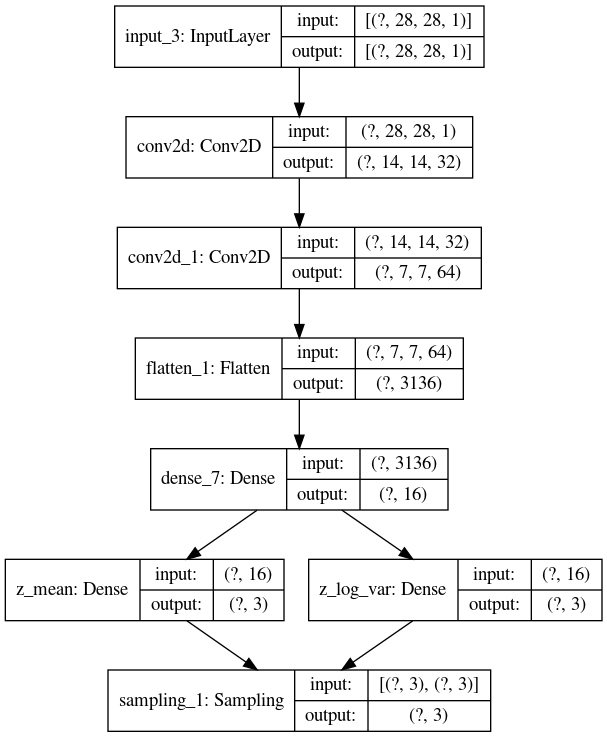

In [19]:
# Plot decoder model.
tf.keras.utils.plot_model(
    model=dc_encoder,
    to_file="vae_dc_encoder_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [20]:
def create_dc_decoder(latent_dim):
    """Creates deep convolutional decoder for VAE.

    Args:
        latent_dim: int, the latent vector dimension length.

    Returns:
        VAE deep convolutional decoder `Model`.
    """
    decoder_inputs = tf.keras.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu")(
        inputs=decoder_inputs
    )
    x = tf.keras.layers.Reshape(target_shape=(7, 7, 64))(inputs=x)
    x = tf.keras.layers.Conv2DTranspose(
        filters=64,
        kernel_size=3,
        strides=2,
        padding="same",
        activation="relu"
    )(inputs=x)
    x = tf.keras.layers.Conv2DTranspose(
        filters=32,
        kernel_size=3,
        strides=2,
        padding="same",
        activation="relu"
    )(inputs=x)
    decoder_outputs = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, padding="same", activation="sigmoid"
    )(inputs=x)

    return tf.keras.Model(
        inputs=decoder_inputs,
        outputs=decoder_outputs,
        name="vae_dc_decoder"
    )

dc_decoder = create_dc_decoder(latent_dim=latent_dim)

dc_decoder.summary()

Model: "vae_dc_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3136)              12544     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
________________________________________________

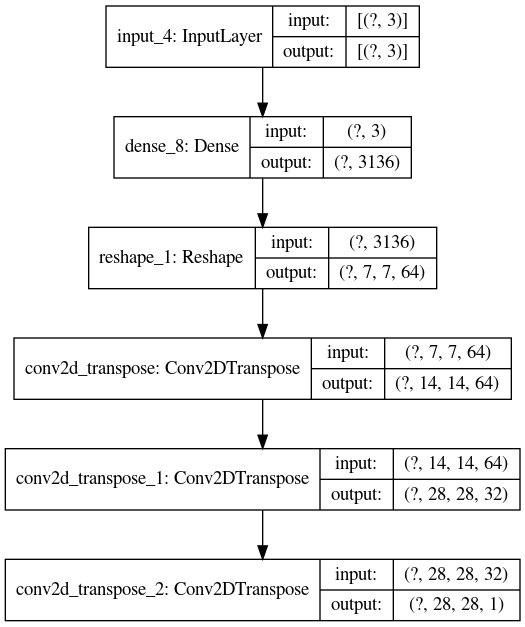

In [21]:
# Plot decoder model.
tf.keras.utils.plot_model(
    model=dc_decoder,
    to_file="vae_dc_decoder_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [22]:
# Instantiate an `VAE` instance using our DC encoder and decoder.
dc_vae = VAE(
    encoder=dc_encoder, decoder=dc_decoder
)

dc_vae.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7
    )
)

# Train DC-VAE model.
dc_vae_history = dc_vae.fit(
    create_dataset(batch_size=128, training=True), epochs=30
)

Epoch 1/30
469/469 [==============================] - 4s 9ms/step - reconstruction_loss: 209.1565 - kl_loss: 4.1338 - loss: 264.4867
Epoch 2/30
469/469 [==============================] - 4s 9ms/step - reconstruction_loss: 164.2599 - kl_loss: 7.1135 - loss: 177.4706
Epoch 3/30
469/469 [==============================] - 4s 9ms/step - reconstruction_loss: 146.7268 - kl_loss: 8.5374 - loss: 157.0586
Epoch 4/30
469/469 [==============================] - 4s 9ms/step - reconstruction_loss: 142.1685 - kl_loss: 8.7049 - loss: 151.0237
Epoch 5/30
469/469 [==============================] - 4s 9ms/step - reconstruction_loss: 139.7380 - kl_loss: 8.7948 - loss: 149.1933
Epoch 6/30
469/469 [==============================] - 4s 9ms/step - reconstruction_loss: 138.1725 - kl_loss: 8.8309 - loss: 147.0765
Epoch 7/30
469/469 [==============================] - 4s 9ms/step - reconstruction_loss: 136.8625 - kl_loss: 8.8469 - loss: 145.8864
Epoch 8/30
469/469 [==============================] - 4s 9ms/step - r

Let's plot the loss history and some generated images using our trained model.

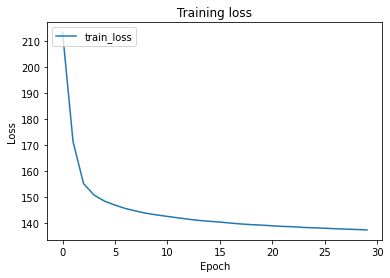

In [23]:
plot_loss_history(history=dc_vae_history)

Both non-variational and variational autoencoders are great at reconstruction.

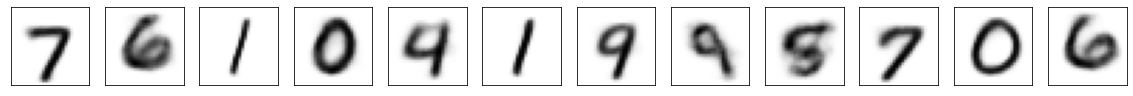

In [24]:
dataset_iter = iter(create_dataset(batch_size=12, training=False))
batch = next(dataset_iter)
plot_images(
    images=dc_vae.decoder(
        inputs=dc_vae.encoder(inputs=batch)
    )
)

And now the latent space is nicely regularized due to the variational aspect, therefore decoding a user provided latent vector performs well.

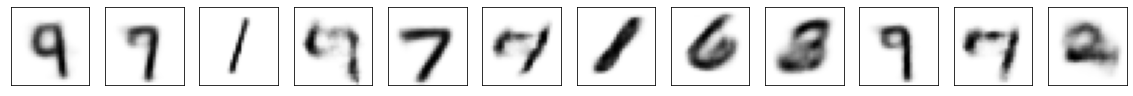

In [25]:
plot_images(
    images=dc_vae.decoder(
        inputs=tf.random.normal(shape=(12, latent_dim))
    )
)